Assumes you have run `Train_Testset.ipynb` first to make the `alldata`, `realdist`, and `balanced` train/test splits for the chosen language pair.

# Imports and setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import panphon
import panphon.distance
import editdistance # levenshtein
import epitran
import eng_to_ipa as eng
from epitran.backoff import Backoff
from googletrans import Translator
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
epitran.download.cedict()

In [4]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import torch
from torch import nn
from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline

In [5]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import numpy as np 
import io
import requests
import csv

In [6]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
#device = torch.device("cuda:0:3" if torch.cuda.is_available() else "cpu") ## specify the GPU id's, GPU id's start from 0.

Using device: cpu



In [323]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

## Load datasets

In [324]:
train_alldata = pd.read_csv('../Datasets/train_final_production_alldata.csv')
test_alldata = pd.read_csv('../Datasets/test_final_production_alldata.csv')

In [325]:
train_realdist = pd.read_csv('../Datasets/train_final_production_realdist.csv')
test_realdist = pd.read_csv('../Datasets/test_final_production_realdist.csv')

In [326]:
train_balanced = pd.read_csv('../Datasets/train_final_production_balanced.csv')
test_balanced = pd.read_csv('../Datasets/test_final_production_balanced.csv')

## Get Panphon phonetic features

In [327]:
#get phonetic features using panPhon
ft = panphon.FeatureTable()

In [328]:
train_alldata['features_loan'] = train_alldata.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
train_alldata['features_orig'] = train_alldata.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)
test_alldata['features_loan'] = test_alldata.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
test_alldata['features_orig'] = test_alldata.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)

train_alldata['features_loan'] = train_alldata['features_loan'].apply(lambda x:sum(x, []))
train_alldata['features_orig'] = train_alldata['features_orig'].apply(lambda x:sum(x, []))
test_alldata['features_orig'] = test_alldata['features_orig'].apply(lambda x:sum(x, []))
test_alldata['features_loan'] = test_alldata['features_loan'].apply(lambda x:sum(x, []))


Pad the phonetic features of the loan word and original word out to the maxlen of the features appearing in the training set (format: `<loan><pad 0s><orig><pad 0s>`).

In [372]:
train_alldata_maxlen = (np.max(train_alldata['features_loan'].str.len()),\
                               np.max(train_alldata['features_orig'].str.len()))

train_alldata['features_loan'] = train_alldata['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
train_alldata['features_orig'] = train_alldata['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

train_alldata['features_loan'][np.random.randint(len(train_alldata['features_loan']))],\
train_alldata['features_orig'][np.random.randint(len(train_alldata['features_loan']))]

(array([-1, -1,  1, -1, -1, -1, -1,  0,  1, -1, -1, -1, -1,  0, -1,  1, -1,
         1, -1, -1,  0, -1,  0,  0,  1,  1, -1,  1, -1, -1, -1,  0,  1, -1,
        -1,  0, -1,  0, -1, -1, -1,  1, -1, -1, -1, -1,  0,  0, -1,  1,  1,
         1,  0, -1, -1,  0,  1, -1, -1,  1,  1, -1, -1,  0,  0,  0, -1, -1,
         0, -1,  0,  0,  1,  1, -1,  1, -1, -1, -1,  0,  1, -1, -1,  0, -1,
         0, -1,  1, -1, -1, -1, -1,  1,  1,  0,  0, -1, -1,  1, -1, -1, -1,
        -1,  0,  1, -1, -1,  1, -1,  0,  1, -1, -1, -1, -1, -1,  0, -1,  0,
         0,  1,  1, -1,  1, -1, -1, -1,  0,  1, -1, -1,  0, -1,  0, -1,  1,
        -1, -1, -1, -1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

In [373]:
test_alldata['features_loan'] = test_alldata['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
test_alldata['features_orig'] = test_alldata['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

test_alldata['features_loan'][np.random.randint(len(test_alldata['features_loan']))],\
test_alldata['features_orig'][np.random.randint(len(test_alldata['features_orig']))]

(array([-1, -1,  1, -1, -1, -1, -1,  0,  1, -1, -1, -1, -1,  0, -1,  1, -1,
         1, -1, -1,  0, -1,  0,  0,  1,  1, -1,  1, -1, -1, -1,  0,  1, -1,
        -1,  0, -1,  0,  1,  1, -1,  1,  1, -1,  1,  1,  0,  0, -1,  1,  1,
        -1, -1, -1,  1,  0,  1, -1, -1, -1, -1,  0, -1,  1, -1,  1, -1, -1,
         0, -1,  0,  0, -1, -1,  1, -1, -1, -1, -1,  0,  1, -1, -1, -1, -1,
         0, -1,  1, -1,  1, -1, -1,  0, -1,  0,  0,  1,  1, -1,  1, -1, -1,
        -1,  0,  1, -1, -1,  0, -1,  0, -1, -1,  1, -1, -1, -1,  1,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 

## Add target labels and make train and test sets

In [331]:
Y_train = np.array([y for y in train_alldata['label_bin']])
Y_test = np.array([y for y in test_alldata['label_bin']])
Y_train.shape,Y_test.shape

((11857,), (1320,))

In [332]:
X_train = np.hstack([np.array([x for x in train_alldata['features_loan']]),\
                     np.array([x for x in train_alldata['features_orig']])])
X_test = np.hstack([np.array([x for x in test_alldata['features_loan']]),\
                    np.array([x for x in test_alldata['features_orig']])])
X_train.shape,X_test.shape

((11857, 1056), (1320, 1056))

Make a validation split for training the DNN model

In [374]:
#create train and validation splits keeping the composition of labels balanced between them using a random state '1 '

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1, stratify=Y_train)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape


(torch.Size([7588, 1056]),
 torch.Size([1897, 1056]),
 torch.Size([7588, 1]),
 torch.Size([1897, 1]))

In [334]:
# n_samples, n_features, n_classes = 10, 2, 2
# data = np.random.randn(n_samples, n_features)  # 10 training examples
# labels = np.random.randint(n_classes, size=n_samples)  # 10 labels

indices = np.arange(X_train.shape[0])
(
    data_train,
    data_test,
    labels_train,
    labels_test,
    indices_train,
    indices_test,
) = train_test_split(X_train, Y_train, indices, test_size=0.2, random_state=1, stratify=Y_train)

In [335]:
indices_train

array([3241, 7760,  947, ..., 4005,  736, 3430])

In [336]:
X_train = torch.tensor(X_train).to(device)
Y_train = torch.tensor(Y_train).to(device).reshape((-1,1))

X_test = torch.tensor(X_test).to(device)
Y_test = torch.tensor(Y_test).to(device).reshape((-1,1))

X_val = torch.tensor(X_val).to(device)
Y_val = torch.tensor(Y_val).to(device).reshape((-1,1))


In [337]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_val.shape, Y_val.shape
 

(torch.Size([9485, 1056]),
 torch.Size([9485, 1]),
 torch.Size([1320, 1056]),
 torch.Size([1320, 1]),
 torch.Size([2372, 1056]),
 torch.Size([2372, 1]))

In [338]:
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=123, stratify=Y_train)
    

In [339]:
sum(Y_val==1)

tensor([242])

In [340]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [341]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_features):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            
        )
        self.dropout = nn.Dropout(0.10) 

    def forward(self, x):
        #x = self.flatten(x)
        #logits = self.linear_relu_stack(x)
        logits_new = self.linear_relu_stack(x)
        logits  = self.dropout(logits_new)
        
        return torch.sigmoid(logits), logits_new
        #return logits

In [342]:
model = NeuralNetwork(X_train.shape[1]).to(device)
#model = NeuralNetwork(X_test.shape[1]).to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1056, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)


In [343]:
# input = torch.randn(5, 5)
# print(input)

In [344]:
# m = nn.Dropout(p=0.5)
# output = m(input)
# print(output)

# model = NeuralNetwork(input.shape[1]).to(device)


In [345]:
model

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1056, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)

In [346]:
criterion = nn.BCELoss().to(device)

In [347]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [348]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5) 
    return ((y_true == predicted).sum().float() / len(y_true), (y_true == predicted).sum())

In [349]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [350]:
CUDA_LAUNCH_BLOCKING=1

In [351]:
#train for 10000 epochs and get the logits 
val_losses = []
train_losses = []
val_accur = []
train_accur = []
logits = []
for epoch in range(5000):

    y_pred = model(X_train.float())[0]
    logits = model(X_train.float())[1]
    #getting logits for test set 
#     y_pred = model(X_test.float())[0]
#     logits = model(X_test.float())[1]
    #y_pred = model(X_train) 
    #print(y_pred)

    #y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, Y_train.float())
    
    #test_loss = criterion(y_pred, Y_test.float())
    #train_loss = criterion(y_pred, Y_train)

    if epoch % 100 == 0:
        train_acc,_ = calculate_accuracy(Y_train, y_pred)

        y_val_pred = model(X_val.float())[0]
        #y_test_pred = torch.squeeze(y_test_pred)
         

        val_loss = criterion(y_val_pred, Y_val.float())

        val_acc, total_corr = calculate_accuracy(Y_val, y_val_pred)
        #print(total_corr)
        
        print(f'''epoch {epoch} Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)} Val set - loss: {round_tensor(val_loss)}, Val accuracy: {round_tensor(val_acc)}
''')
        #print(f'''epoch {epoch}Train set - loss: {round_tensor(train_loss)} ''')
        #print(f'''epoch {epoch}Test set - loss: {round_tensor(test_loss)} ''')
        train_losses.append(train_loss.detach().numpy())
        val_losses.append(val_loss.detach().numpy())
        
        val_accur.append(val_acc.detach().numpy())
        train_accur.append(train_acc.detach().numpy())

    optimizer.zero_grad()

    train_loss.backward()
    #test_loss.backward()

    optimizer.step()

epoch 0 Train set - loss: 0.681, accuracy: 0.745 Val  set - loss: 0.681, Val accuracy: 0.738

epoch 100 Train set - loss: 0.464, accuracy: 0.819 Val  set - loss: 0.465, Val accuracy: 0.817

epoch 200 Train set - loss: 0.355, accuracy: 0.818 Val  set - loss: 0.356, Val accuracy: 0.819

epoch 300 Train set - loss: 0.345, accuracy: 0.822 Val  set - loss: 0.352, Val accuracy: 0.814

epoch 400 Train set - loss: 0.344, accuracy: 0.817 Val  set - loss: 0.341, Val accuracy: 0.823

epoch 500 Train set - loss: 0.337, accuracy: 0.82 Val  set - loss: 0.334, Val accuracy: 0.827

epoch 600 Train set - loss: 0.336, accuracy: 0.815 Val  set - loss: 0.338, Val accuracy: 0.815

epoch 700 Train set - loss: 0.327, accuracy: 0.818 Val  set - loss: 0.336, Val accuracy: 0.81

epoch 800 Train set - loss: 0.323, accuracy: 0.816 Val  set - loss: 0.327, Val accuracy: 0.816

epoch 900 Train set - loss: 0.312, accuracy: 0.822 Val  set - loss: 0.32, Val accuracy: 0.815

epoch 1000 Train set - loss: 0.303, accuracy:

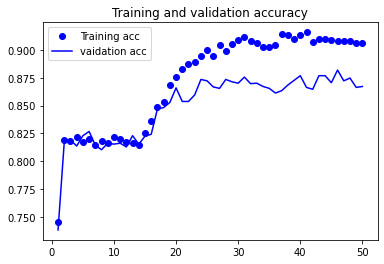

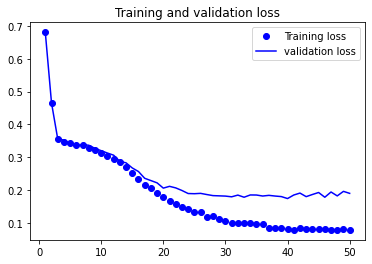

In [352]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accur) + 1)

plt.plot(epochs, train_accur, 'bo', label='Training acc')
plt.plot(epochs, val_accur, 'b', label='vaidation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [353]:
train_realdist['features_loan'] = train_realdist.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
train_realdist['features_orig'] = train_realdist.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)
test_realdist['features_loan'] = test_realdist.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
test_realdist['features_orig'] = test_realdist.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)

train_realdist['features_loan'] = train_realdist['features_loan'].apply(lambda x:sum(x, []))
train_realdist['features_orig'] = train_realdist['features_orig'].apply(lambda x:sum(x, []))
test_realdist['features_orig'] = test_realdist['features_orig'].apply(lambda x:sum(x, []))
test_realdist['features_loan'] = test_realdist['features_loan'].apply(lambda x:sum(x, []))

train_balanced['features_loan'] = train_balanced.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
train_balanced['features_orig'] = train_balanced.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)
test_balanced['features_loan'] = test_balanced.apply(lambda x:ft.word_to_vector_list(x["loan_word_epitran"],numeric=True ), axis=1)
test_balanced['features_orig'] = test_balanced.apply(lambda x:ft.word_to_vector_list(x["original_word_epitran"],numeric=True ), axis=1)

train_balanced['features_loan'] = train_balanced['features_loan'].apply(lambda x:sum(x, []))
train_balanced['features_orig'] = train_balanced['features_orig'].apply(lambda x:sum(x, []))
test_balanced['features_orig'] = test_balanced['features_orig'].apply(lambda x:sum(x, []))
test_balanced['features_loan'] = test_balanced['features_loan'].apply(lambda x:sum(x, []))


In [362]:
test_alldata['features_loan'] = test_alldata['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
test_alldata['features_orig'] = test_alldata['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

X_train_alldata = torch.tensor(np.hstack([np.array([x for x in train_alldata['features_loan']]),\
                     np.array([x for x in train_alldata['features_orig']])])).to(device)
X_test_alldata = torch.tensor(np.hstack([np.array([x for x in test_alldata['features_loan']]),\
                    np.array([x for x in test_alldata['features_orig']])])).to(device)

In [363]:
train_realdist['features_loan'] = train_realdist['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
train_realdist['features_orig'] = train_realdist['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

test_realdist['features_loan'] = test_realdist['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
test_realdist['features_orig'] = test_realdist['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

X_train_realdist = torch.tensor(np.hstack([np.array([x for x in train_realdist['features_loan']]),\
                     np.array([x for x in train_realdist['features_orig']])])).to(device)
X_test_realdist = torch.tensor(np.hstack([np.array([x for x in test_realdist['features_loan']]),\
                    np.array([x for x in test_realdist['features_orig']])])).to(device)

train_balanced['features_loan'] = train_balanced['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
train_balanced['features_orig'] = train_balanced['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

test_balanced['features_loan'] = test_balanced['features_loan'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[0]-len(x)), 'constant'))
test_balanced['features_orig'] = test_balanced['features_orig'].apply(lambda x: \
                                np.pad(x,\
                                (0,train_alldata_maxlen[1]-len(x)), 'constant'))

X_train_balanced = torch.tensor(np.hstack([np.array([x for x in train_balanced['features_loan']]),\
                     np.array([x for x in train_balanced['features_orig']])])).to(device)
X_test_balanced = torch.tensor(np.hstack([np.array([x for x in test_balanced['features_loan']]),\
                    np.array([x for x in test_balanced['features_orig']])])).to(device)

In [364]:
model.eval()

with torch.no_grad():
    train_logits_dnn_alldata = model(X_train_alldata.float())[1].detach().cpu().numpy()
    test_logits_dnn_alldata = model(X_test_alldata.float())[1].detach().cpu().numpy()
    train_logits_dnn_realdist = model(X_train_realdist.float())[1].detach().cpu().numpy()
    test_logits_dnn_realdist = model(X_test_realdist.float())[1].detach().cpu().numpy()
    train_logits_dnn_balanced = model(X_train_balanced.float())[1].detach().cpu().numpy()
    test_logits_dnn_balanced = model(X_test_balanced.float())[1].detach().cpu().numpy()

In [367]:
train_logits_dnn_alldata, test_logits_dnn_alldata,\
train_logits_dnn_realdist, test_logits_dnn_realdist,\
train_logits_dnn_balanced, test_logits_dnn_balanced

(array([[ -8.168253 ],
        [  5.6654778],
        [ -1.99144  ],
        ...,
        [-25.142923 ],
        [ -9.857235 ],
        [-11.477509 ]], dtype=float32),
 array([[ -6.632645 ],
        [-12.517828 ],
        [ -4.8939857],
        ...,
        [  4.328829 ],
        [ -5.4864573],
        [  6.445583 ]], dtype=float32),
 array([[-12.112804 ],
        [  3.9351969],
        [  4.503063 ],
        ...,
        [-20.006413 ],
        [ -8.729936 ],
        [-16.542418 ]], dtype=float32),
 array([[-1.58126945e+01],
        [-1.23463612e+01],
        [ 2.20779514e+00],
        [-2.12806282e+01],
        [-2.41199265e+01],
        [-9.40355301e-01],
        [ 3.53277159e+00],
        [-5.31555843e+00],
        [-2.13989716e+01],
        [-1.03952007e+01],
        [-6.83899879e+00],
        [-2.36320710e+00],
        [-1.96180267e+01],
        [-1.43530643e+00],
        [-1.01868916e+01],
        [-1.52589712e+01],
        [-9.01798248e+00],
        [-7.16112375e+00],
        [ 

In [369]:
train_alldata_dnnlogits = pd.read_csv('../Datasets/train_final_production_alldata.csv')
test_alldata_dnnlogits = pd.read_csv('../Datasets/test_final_production_alldata.csv')
train_realdist_dnnlogits = pd.read_csv('../Datasets/train_final_production_realdist.csv')
test_realdist_dnnlogits = pd.read_csv('../Datasets/test_final_production_realdist.csv')
train_balanced_dnnlogits = pd.read_csv('../Datasets/train_final_production_balanced.csv')
test_balanced_dnnlogits = pd.read_csv('../Datasets/test_final_production_balanced.csv')

In [371]:
train_alldata_dnnlogits['DNNlogits_modelpredicted'] = train_logits_dnn_alldata
test_alldata_dnnlogits['DNNlogits_modelpredicted'] = test_logits_dnn_alldata

train_realdist_dnnlogits['DNNlogits_modelpredicted'] = train_logits_dnn_realdist
test_realdist_dnnlogits['DNNlogits_modelpredicted'] = test_logits_dnn_realdist

train_balanced_dnnlogits['DNNlogits_modelpredicted'] = train_logits_dnn_balanced
test_balanced_dnnlogits['DNNlogits_modelpredicted'] = test_logits_dnn_balanced

train_alldata_dnnlogits.to_csv('../Datasets/modelpredictedlogits_trainDNN_alldata.csv')
test_alldata_dnnlogits.to_csv('../Datasets/modelpredictedlogits_testDNN_alldata.csv')

train_realdist_dnnlogits.to_csv('../Datasets/modelpredictedlogits_trainDNN_realdist.csv')
test_realdist_dnnlogits.to_csv('../Datasets/modelpredictedlogits_testDNN_realdist.csv')

train_balanced_dnnlogits.to_csv('../Datasets/modelpredictedlogits_trainDNN_balanced.csv')
test_balanced_dnnlogits.to_csv('../Datasets/modelpredictedlogits_testDNN_balanced.csv')


In [286]:
x_train_alldata.shape, x_test_alldata.shape#x_train_realdist.shape, x_test_realdist.shape, x_train_balanced.shape,  x_test_balanced.shape

((23714,), (2634,))

In [40]:
#create the entire  train set for all three types of datasets to predict using the trained model now, pad the train test sets to fit the trained model dimensions 

# all data
X_train_dnn_alldata = x_train_alldata[:,0:1056]
X_train_dnn_alldata  = torch.tensor(X_train_dnn_alldata).to(device)
X_test_dnn_alldata = torch.tensor(x_test_alldata[:,0:960])
X_test_dnn_alldata = F.pad(X_test_dnn_alldata,pad =(0, 1056-X_test_dnn_alldata.shape[1]), value=0).to(device)
#X_test_dnn_alldata  = torch.tensor(X_test_dnn_alldata).to(device)

#real dist 

X_train_dnn_realdist = torch.tensor(x_train_realdist[:,0:864])
X_train_dnn_realdist = F.pad(X_train_dnn_realdist,pad =(0, 1056-X_train_dnn_realdist.shape[1]), value=0).to(device) 


X_test_dnn_realdist = torch.tensor(x_test_realdist[:,0:768])
X_test_dnn_realdist = F.pad(X_test_dnn_realdist,pad =(0, 1056-X_test_dnn_realdist.shape[1]), value=0).to(device) 

# balanced 
X_train_dnn_balanced = torch.tensor(x_train_balanced[:,0:840])
X_train_dnn_balanced = F.pad(X_train_dnn_balanced,pad =(0, 1056-X_train_dnn_balanced.shape[1]), value=0).to(device) 


X_test_dnn_balanced = torch.tensor(x_test_balanced[:,0:768])
X_test_dnn_balanced = F.pad(X_test_dnn_balanced,pad =(0, 1056-X_test_dnn_balanced.shape[1]), value=0).to(device) 





In [41]:
X_train_dnn_alldata.shape, X_test_dnn_alldata.shape, X_train_dnn_realdist.shape, X_test_dnn_realdist.shape, X_train_dnn_balanced.shape,X_test_dnn_balanced.shape 

(torch.Size([11832, 1056]),
 torch.Size([1329, 1056]),
 torch.Size([4200, 1056]),
 torch.Size([462, 1056]),
 torch.Size([2407, 1056]),
 torch.Size([287, 1056]))

In [45]:
# evaluate model, that is get the logits for the test set:
model.eval()

with torch.no_grad():
    train_logits_dnn_alldata = model(X_train_dnn_alldata.float())[1].detach().cpu().numpy()
    test_logits_dnn_alldata = model(X_test_dnn_alldata.float())[1].detach().cpu().numpy()
    train_logits_dnn_realdist = model(X_train_dnn_realdist.float())[1].detach().cpu().numpy()
    test_logits_dnn_realdist = model(X_test_dnn_realdist.float())[1].detach().cpu().numpy()
    train_logits_dnn_balanced = model( X_train_dnn_balanced.float())[1].detach().cpu().numpy()
    test_logits_dnn_balanced = model( X_test_dnn_balanced.float())[1].detach().cpu().numpy()
    
 
 

In [46]:
train_logits_dnn_alldata.shape, test_logits_dnn_alldata.shape, train_logits_dnn_realdist.shape, test_logits_dnn_realdist.shape,train_logits_dnn_balanced.shape,test_logits_dnn_balanced.shape  
 

((11832, 1), (1329, 1), (4200, 1), (462, 1), (2407, 1), (287, 1))

In [54]:
# train_acc = train_acc.detach().cpu().numpy()
train_alldata = pd.read_csv('/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/modelpredictedlogits_trainCNN_alldata.csv')
test_alldata = pd.read_csv('/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/modelpredictedlogits_testCNN_alldata.csv')

train_realdist = pd.read_csv('/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/modelpredictedlogits_trainCNN_realdist.csv')
test_realdist = pd.read_csv('/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/modelpredictedlogits_testCNN_realdist.csv')

train_balanced = pd.read_csv('/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/modelpredictedlogits_trainCNN_balanced.csv')
test_balanced = pd.read_csv('/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/modelpredictedlogits_testCNN_balanced.csv')

In [55]:
train_alldata['DNNlogits_modelpredicted'] = train_logits_dnn_alldata
test_alldata['DNNlogits_modelpredicted'] = test_logits_dnn_alldata

train_realdist['DNNlogits_modelpredicted'] = train_logits_dnn_realdist
test_realdist['DNNlogits_modelpredicted'] = test_logits_dnn_realdist

train_balanced['DNNlogits_modelpredicted'] = train_logits_dnn_balanced
test_balanced['DNNlogits_modelpredicted'] = test_logits_dnn_balanced



In [58]:
train_alldata.to_csv('modelpredictedlogits_trainCNN_DNN_alldata.csv')
test_alldata.to_csv('modelpredictedlogits_testCNN_DNN_alldata.csv')

train_realdist.to_csv('modelpredictedlogits_trainCNN_DNN_realdist.csv')
test_realdist.to_csv('modelpredictedlogits_testCNN_DNN_realdist.csv')

train_balanced.to_csv('modelpredictedlogits_trainCNN_DNN_balanced.csv')
test_balanced.to_csv('modelpredictedlogits_testCNN_DNN_balanced.csv')


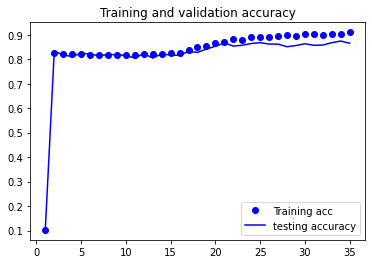

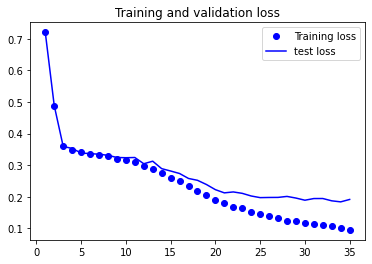

In [34]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accur) + 1)

plt.plot(epochs, train_accur, 'bo', label='Training acc')
plt.plot(epochs, val_accur, 'b', label='testing accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='test loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
train_acc

In [ ]:
logits.shape

In [35]:
train_logits = train_logits.detach().cpu().numpy()
test_logits = test_logits.detach().cpu().numpy()

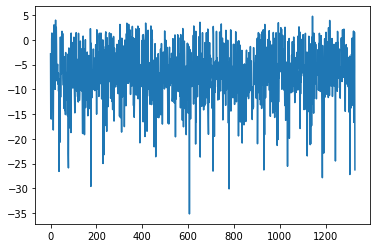

In [36]:
plt.plot(test_logits)
plt.show()

In [ ]:
# x_coordinate = [ 25 * i for i in range(len(logits_new)) ]
# plt.plot(x_coordinate,logits_new)
# plt.show()

In [37]:
np.min(test_logits), np.max(test_logits),np.mean(test_logits)

(-35.16361, 4.748599, -6.883185)

In [ ]:
#train_logits = train_logits.detach().cpu().numpy()
plt.plot(train_logits[:1200])
plt.show()

In [ ]:
np.min(train_logits), np.max(train_logits),np.mean(train_logits)

In [ ]:
#url_train_logits = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/real_distribution/train_withlogits_realdist.csv'
url_train_logits = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/alldata/train_withlogits_alldata.csv'
#url_test_logits = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/real_distribution/test_withlogits_realdist.csv'

url_test_logits = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/alldata/test_withlogits_alldata.csv'


url_train_logits = requests.get(url_train_logits).content
url_test_logits = requests.get(url_test_logits).content
train=pd.read_csv(io.StringIO(url_train_logits.decode('utf-8')))
test = pd.read_csv(io.StringIO(url_test_logits.decode('utf-8')))

In [ ]:
train.shape, test.shape

In [ ]:
train['predicted_DNN_logits'] = train_logits

In [ ]:
test['predicted_DNN_logits'] = test_logits

In [ ]:
test.to_csv('modelpredictedlogits_test.csv')
train.to_csv('modelpredictedlogits_train.csv')


# now get the predicted logits for train-test from CNNS

In [ ]:
X_train = x_train_alldata[:,0:1056]
Y_train = x_train_alldata[:,1056] 
 
X_test =  x_test_alldata[:,0:960]
Y_test =  x_test_alldata[:,960] 

In [ ]:
#create train and validation splits for proper model training while keeping the composition of labels balanced between them using a random state '1 '

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1, stratify=Y_train)

In [ ]:
# convert them to torch tensors for padding
X_train = torch.tensor(X_train).to(device)
Y_train = torch.tensor(Y_train).to(device).reshape((-1,1))

X_test= torch.tensor(X_test).to(device)
Y_test = torch.tensor(Y_test).to(device).reshape((-1,1))

X_val= torch.tensor(X_val).to(device)
Y_val = torch.tensor(Y_val).to(device).reshape((-1,1))


In [ ]:

X_train.shape, X_val.shape

In [ ]:
#X_train_CNN = F.pad(X_train,pad =(0, 1089-X_train.shape[1]), value=0)
#X_train_CNN = F.pad(X_train,pad =(0, 900-X_train.shape[1]), value=0)  # 900 is closest perfect square to 864 for real dist train set
#X_train_CNN = F.pad(X_train,pad =(0, 841-X_train.shape[1]), value=0)  # 841 is closest perfect square to 840 for balanced train set
X_train_CNN = F.pad(X_train,pad =(0, 1089-X_train.shape[1]), value=0) #for cnns and for predicting with trained model , perfect sq is 1089 closest to 1056
Y_train_CNN = Y_train
X_val_CNN = F.pad(X_val,pad =(0, 1089-X_val.shape[1]), value=0) #validatin set: for cnns and for predicting with trained model , perfect sq is 1089 closest to 1056
Y_val_CNN = Y_val
#X_test_CNN = F.pad(X_test,pad =(0, 900-X_test.shape[1]), value=0)
#X_test_CNN = F.pad(X_test,pad =(0, 961-X_test.shape[1]), value=0) #for alldata test set, 961 because perfect square of 31 is 961 which is closest to 960 i.e our original concatenated panphon feature dimension 
#X_test_CNN = F.pad(X_test,pad =(0, 784-X_test.shape[1]), value=0) #for real dist test set and balanced test set, 784 because perfect square of 28 is 784 which is closest to 768 i.e our original concatenated panphon feature dimension

X_test_CNN = F.pad(X_test,pad =(0, 1089-X_test.shape[1]), value=0) #for all data and with trained model prediction for logits, 1809 closes to 1056
Y_test_CNN = Y_test

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

In [ ]:
X_train_CNN.shape, Y_train_CNN.shape, X_test_CNN.shape, Y_test_CNN.shape, X_val_CNN.shape, Y_val_CNN.shape

In [ ]:
class CCN_Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 2) # input is 1 image, 32 output channels, 2X2 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 2) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128,2)
        

        #x = torch.randn(23,23).view(-1,1,23,23)
        #x = torch.randn(33,33).view(-1,1,33,33) #33 because its the square root of 1089
        #x = torch.randn(30,30).view(-1,1,30,30) #30 because its the square root of 900 for real dist train set
        #x = torch.randn(29,29).view(-1,1,29,29) #29 because its the square root of 841 for balanced train set
        x = torch.randn(33,33).view(-1,1,33,33) # for trained model logit prediction, for all data, 1089 is sq of 33
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 1) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).
        self.dropout = nn.Dropout(0.2)

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.tanh(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.tanh(self.conv3(x)), (2, 2))
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
#         x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = self.dropout(x)
        x = F.tanh(self.fc1(x))
        #x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.sigmoid(x), x, #comment it out to get the logits in the return statement 
        #return x
                         


CNN_Net = CCN_Net() 
CNN_Net= nn.DataParallel(CNN_Net)
CNN_Net.to(device)
print(CNN_Net)

In [ ]:
CNN_Net

In [ ]:
#X_train = torch.tensor(X_train).view(-1,23,23).to(device)
#X_train_CNN = torch.tensor(X_train_CNN).view(-1,33,33).to(device)
#X_train_CNN = torch.tensor(X_train_CNN).view(-1,30,30).to(device) #30 for real dist train set w/o trained model predicting
#X_train_CNN = torch.tensor(X_train_CNN).view(-1,29,29).to(device) #29 for balanced train set w/o trained model predicting

X_train_CNN = torch.tensor(X_train_CNN).view(-1,33,33).to(device) #33 for all data trainset with trained model predicting
X_val_CNN = torch.tensor(X_val_CNN).view(-1,33,33).to(device) # for model predict, val set as above
X_test_CNN = torch.tensor(X_test_CNN).view(-1,33,33).to(device) # for model predict test set as above
#X_train = torch.tensor(X_train).to(device)
#Y_train = torch.tensor(Y_train).to(device)
Y_train_CNN = torch.tensor(Y_train_CNN).to(device)
Y_val_CNN = torch.tensor(Y_val_CNN).to(device)
Y_test_CNN = torch.tensor(Y_test_CNN).to(device)

#X_test = torch.tensor(X_test).view(-1,23,23).to(device)

In [ ]:
X_train_CNN.shape, Y_train_CNN.shape, X_test_CNN.shape, Y_test_CNN.shape, X_val_CNN.shape, Y_val_CNN.shape
Y_train_CNN
sum(Y_train_CNN ==1)

In [ ]:
#optimizer = optim.Adam(CNN_Net.parameters(), lr=0.01)
optimizer = optim.SGD(CNN_Net.parameters(),lr=0.001, momentum=0.0,  weight_decay=0.0, nesterov=False)
#optimizer = torch.optim.RMSprop(CNN_Net.parameters(), lr=0.00001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
#loss_function = nn.MSELoss()
scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
loss_function = nn.BCELoss().to(device)

In [ ]:
from tqdm import tqdm

In [ ]:
torch.cuda.empty_cache()

In [ ]:
X_val_CNN= X_val_CNN.unsqueeze(1) #just do it once 
X_test_CNN = X_test_CNN .unsqueeze(1)

In [ ]:
# sets the seed manually to 42
torch.manual_seed(42)
# a = X_val_CNN[torch.randint(len(X_val_CNN), (120,))]  
# # b = Y_val_CNN[torch.randint(len(X_val_CNN), (120,))]  
# # a.shape
# b

# 

In [ ]:
torch.initial_seed()

In [ ]:
#train for 10000 epochs and get the logits 
val_losses = []
train_losses = []
val_accur = []
train_accur = []
train_losses_batch = []
logits = []
BATCH_SIZE = 512
for epoch in range(50):
    for i in tqdm(range(0, len(X_train_CNN), BATCH_SIZE)):
        batch_X = X_train_CNN[i:i+BATCH_SIZE].view(-1, 1, 33,33)  
        #batch_X = X_train_CNN.view(-1, 1, 29,29)  
        batch_y = Y_train_CNN[i:i+BATCH_SIZE]
        
        

        #X_train_CNN = X_train_CNN.view(-1, 1, 33,33) # for balanced train set
        CNN_Net.zero_grad()
        
        y_pred = CNN_Net(batch_X .float())[0]
        #print(y_pred)
        logits = CNN_Net(batch_X.float())[1]
        #getting logits for test set 
    #     y_pred = model(X_test.float())[0]
    #     logits = model(X_test.float())[1]
        #y_pred = model(X_train) 
        #print(y_pred)

        #y_pred = torch.squeeze(y_pred)
        train_loss = loss_function(y_pred, batch_y.float())

        #test_loss = criterion(y_pred, Y_test.float())
        #train_loss = criterion(y_pred, Y_train)
        train_losses.append(train_loss)
        if epoch % 5 == 0:
            with torch.no_grad():
                CNN_Net.eval()

                val_batch_X = X_val_CNN[torch.randint(len(X_val_CNN), (BATCH_SIZE,))] 
                val_batch_Y = Y_val_CNN[torch.randint(len(X_val_CNN), (BATCH_SIZE,))] 

                train_acc,_ = calculate_accuracy(batch_y, y_pred)
                #X_val_CNN= X_val_CNN.unsqueeze(1) don't do it here, it will keep adding a channel dimension every time the for loop operates
                y_val_pred = CNN_Net(val_batch_X.float())[0]
                #print(y_val_pred)
                #y_test_pred = torch.squeeze(y_test_pred)


                val_loss = loss_function(y_val_pred, val_batch_Y.float())

                val_acc, total_corr = calculate_accuracy(val_batch_Y, y_val_pred)
                #print(total_corr)

                print(f'''epoch {epoch}Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}Val  set - loss: {round_tensor(val_loss)}, Val accuracy: {round_tensor(val_acc)}
        ''')
                #print(f'''epoch {epoch}Train set - loss: {round_tensor(train_loss)} ''')
                #print(f'''epoch {epoch}Test set - loss: {round_tensor(test_loss)} ''')
                train_losses_batch.append(train_loss)
                val_losses.append(val_loss)

                val_accur.append(val_acc)
                train_accur.append(train_acc)

        optimizer.zero_grad()

        train_loss.backward()
        #test_loss.backward()

        optimizer.step()
    scheduler1.step()

In [ ]:
len(train_accur)
plt.plot(train_losses)

plt.plot(train_losses)
len(train_accur)

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accur) + 1)

plt.plot(epochs, train_accur, 'bo', label='Training acc')
plt.plot(epochs, val_accur, 'b', label='vaidation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses_batch, 'bo', label='Training loss every epoch multiple of 5')
plt.plot(epochs, val_losses, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
torch.save(CNN_Net, '/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/logits_CNNmodel/logits_cnn_model')

In [ ]:
CNN_Net

In [ ]:
cnn_model = torch.load('/s/chopin/d/proj/ramfis-aida/MachineTranslationIPA/logits_CNNmodel/logits_cnn_model')

In [ ]:
cnn_model.state_dict()

In [ ]:
X_train_CNN.view(-1, 1, 33,33)  



# Inference phase for all three train-test splits using cnn model that was trained using the whole dataset, pad all three sets to suit the dimensions of the cnn trained model for inference and call model.eval

In [ ]:
x_train_alldata.shape, x_test_alldata.shape,x_train_realdist.shape, x_test_realdist.shape, x_train_balanced.shape,  x_test_balanced.shape

# get base train and test sets for all three types of train test splits, one by one 

In [ ]:

# get base train and test sets for all three types of train test splits, one by one 

#  1 - all data set
X_train_alldata_cnn = x_train_alldata[:,0:1056]
 
X_test_alldata_cnn = x_test_alldata[:,0:960]
 
X_train_alldata_cnn = torch.tensor(X_train_alldata_cnn).to(device)
X_test_alldata_cnn = torch.tensor(X_test_alldata_cnn).to(device)


# 2- real distribution set
X_train_realdist_cnn = x_train_realdist[:,0:864]
X_test_realdist_cnn = x_test_realdist[:,0:768]
 
X_train_realdist_cnn = torch.tensor(X_train_realdist_cnn).to(device)
X_test_realdist_cnn = torch.tensor(X_test_realdist_cnn).to(device)


# 3 - balanced dataset splits 

X_train_balanced_cnn = x_train_balanced[:,0:840]
X_test_balanced_cnn = x_test_balanced[:,0:768]
 
X_train_balanced_cnn = torch.tensor(X_train_balanced_cnn).to(device)
X_test_balanced_cnn = torch.tensor(X_test_balanced_cnn).to(device)

# pad for inference, for all three train and test splits 
 
    
X_train_alldata_cnn = F.pad(X_train_alldata_cnn,pad =(0, 1089-X_train_alldata_cnn.shape[1]), value=0) #for cnns and for predicting with trained model , perfect sq is 1089 closest to 1056
X_test_alldata_cnn = F.pad(X_test_alldata_cnn,pad =(0, 1089-X_test_alldata_cnn.shape[1]), value=0) #for all data and with trained model prediction for logits, 1809 closes to 1056
 
X_train_realdist_cnn = F.pad(X_train_realdist_cnn,pad =(0, 1089-X_train_realdist_cnn.shape[1]), value=0)
X_test_realdist_cnn = F.pad(X_test_realdist_cnn,pad =(0, 1089-X_test_realdist_cnn.shape[1]), value=0)

X_train_balanced_cnn = F.pad(X_train_balanced_cnn,pad =(0, 1089-X_train_balanced_cnn.shape[1]), value=0)
X_test_balanced_cnn = F.pad(X_test_balanced_cnn,pad =(0, 1089-X_test_balanced_cnn.shape[1]), value=0)






In [ ]:
# reshape these tensors into cnn dimensions for inference 


X_train_alldata_cnn = torch.tensor(X_train_alldata_cnn).view(-1,1,33,33).to(device) 
 
X_test_alldata_cnn = torch.tensor(X_test_alldata_cnn).view(-1,1, 33,33).to(device)  

X_train_realdist_cnn = torch.tensor(X_train_realdist_cnn).view(-1,1, 33,33).to(device) 

X_test_realdist_cnn = torch.tensor(X_test_realdist_cnn).view(-1,1, 33,33).to(device) 

X_train_balanced_cnn = torch.tensor(X_train_balanced_cnn).view(-1,1, 33,33).to(device) 

X_test_balanced_cnn = torch.tensor(X_test_balanced_cnn).view(-1,1, 33,33).to(device) 


#X_train = torch.tensor(X_train).to(device)
#Y_train = torch.tensor(Y_train).to(device)
# Y_train_CNN = torch.tensor(Y_train_CNN).to(device)
# Y_val_CNN = torch.tensor(Y_val_CNN).to(device)
# Y_test_CNN = torch.tensor(Y_test_CNN).to(device)

In [ ]:
X_train_alldata_cnn.shape, X_test_alldata_cnn.shape, X_train_realdist_cnn.shape, X_test_realdist_cnn.shape, X_train_balanced_cnn.shape,X_test_balanced_cnn.shape
 
 

In [ ]:
# use the trained CNN model to get logits for the three different splits

cnn_model.eval()

with torch.no_grad():
    train_logits_cnn_alldata = cnn_model(X_train_alldata_cnn.float())[1]
    test_logits_cnn_alldata = cnn_model( X_test_alldata_cnn.float())[1]
    
    train_logits_cnn_realdist = cnn_model(X_train_realdist_cnn.float())[1]
    test_logits_cnn_realdist = cnn_model( X_test_realdist_cnn.float())[1]
    
    train_logits_cnn_balanced = cnn_model(X_train_balanced_cnn.float())[1]
    test_logits_cnn_balanced = cnn_model( X_test_balanced_cnn.float())[1]
    


In [ ]:
train_logits_cnn_alldata = train_logits_cnn_alldata.detach().cpu().numpy()
test_logits_cnn_alldata = test_logits_cnn_alldata.detach().cpu().numpy()

train_logits_cnn_realdist = train_logits_cnn_realdist.detach().cpu().numpy()
test_logits_cnn_realdist = test_logits_cnn_realdist.detach().cpu().numpy()

train_logits_cnn_balanced = train_logits_cnn_balanced.detach().cpu().numpy()
test_logits_cnn_balanced = test_logits_cnn_balanced.detach().cpu().numpy()



In [ ]:
len(train_logits_cnn_alldata), len(test_logits_cnn_alldata), len(train_logits_cnn_realdist), len(test_logits_cnn_realdist),train_logits_cnn_balanced.shape, test_logits_cnn_balanced.shape

In [ ]:
plt.plot(train_logits_cnn_balanced)
plt.plot(test_logits_cnn_balanced)



In [ ]:
#url_train_logits = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/real_distribution/train_withlogits_realdist.csv'
url_train_logits = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/balanced_splits/train_withlogits_balanced.csv'
#url_train_logits = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/alldata/train_withlogits_alldata.csv'
#url_test_logits = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/real_distribution/test_withlogits_realdist.csv'
url_test_logits = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/balanced_splits/test_withlogits_balanced.csv'

#url_test_logits = 'https://raw.githubusercontent.com/csu-signal/loan-word-detection/main/Datasets/production_train_test/alldata/test_withlogits_alldata.csv'


url_train_logits = requests.get(url_train_logits).content
url_test_logits = requests.get(url_test_logits).content
# train_alldata=pd.read_csv(io.StringIO(url_train_logits.decode('utf-8')))
# test_alldata = pd.read_csv(io.StringIO(url_test_logits.decode('utf-8')))

# train_realdist=pd.read_csv(io.StringIO(url_train_logits.decode('utf-8')))
# test_realdist = pd.read_csv(io.StringIO(url_test_logits.decode('utf-8')))

train_balanced=pd.read_csv(io.StringIO(url_train_logits.decode('utf-8')))
test_balanced = pd.read_csv(io.StringIO(url_test_logits.decode('utf-8')))

In [ ]:
test_balanced.shape

In [ ]:
# train_alldata['CNNlogits_modelpredicted'] = train_logits_cnn_alldata
# test_alldata['CNNlogits_modelpredicted'] =  test_logits_cnn_alldata

# train_realdist['CNNlogits_modelpredicted'] = train_logits_cnn_realdist
# test_realdist['CNNlogits_modelpredicted'] =  test_logits_cnn_realdist

train_balanced['CNNlogits_modelpredicted'] = train_logits_cnn_balanced
test_balanced['CNNlogits_modelpredicted'] =  test_logits_cnn_balanced




In [48]:
train_realdist.shape

NameError: name 'train_realdist' is not defined

In [ ]:
# train_alldata.to_csv('modelpredictedlogits_trainCNN.csv')
# test_alldata.to_csv('modelpredictedlogits_testCNN.csv')


# train_realdist.to_csv('modelpredictedlogits_trainCNN_realdist.csv')
# test_realdist.to_csv('modelpredictedlogits_testCNN_realdist.csv')

train_balanced.to_csv('modelpredictedlogits_trainCNN_balanced.csv')
test_balanced.to_csv('modelpredictedlogits_testCNN_balanced.csv')


In [ ]:
loss_cnn_train = []
#EPOCHS = 3000  # for the specific case of CNN logits real dist train set, in order for the train loss to converge, rest all were trained to 1000 epochs 
EPOCHS = 1000
BATCH_SIZE = 120
cnn_logits_lst = []
 
for epoch in range(EPOCHS):
    #for i in tqdm(range(0, len(X_train_CNN), BATCH_SIZE)):
    #batch_X = X_train_CNN.view(-1, 1, 30,30) #for real dist 
    batch_X = X_train_CNN.view(-1, 1, 29,29) # for balanced train set
    batch_y = Y_train_CNN


    net.zero_grad()
    outputs = net(batch_X.float())[0]
    cnn_logits = net(batch_X.float())[1]
    #cnn_logits_lst.extend(cnn_logits)
    #print(outputs)
    loss = loss_function(outputs,  batch_y.float().reshape((-1,1)))

    loss.backward()
    optimizer.step()
    loss_cnn_train.append(loss)
    if EPOCHS % 100 == 0:
        print(f"Epoch: {epoch}. Loss: {loss}")